# Create new northern boundary conditions to see what would happen if the TPD from the Arctic Ocean feeds the Canada Basin

In [10]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import scipy.ndimage as ndimage
import matplotlib
import xarray as xr
import gsw

%matplotlib inline

##### Parameters:

In [11]:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

In [12]:
rimwidth_north = 10 # western Canada Basin
rimwidth_east  = 20 # northern Canada Basin
rimwidth_south = 10 # Baffin Bay

In [13]:
# land_color = "#8b7765"
land_color = '#a9a7a2'

In [14]:
N_coordinates = ((2168, 2178, 201, 798))
E_coordinates = ((1481, 2178, 778, 798))
S_coordinates = ((1482, 1492, 181, 798))

##### Functions:

In [15]:
def flatten_input(var):
    b = var[0,:,:].flatten()
    for i in range(1,len(var)):
        a = var[i,:,:].flatten()
        b = np.vstack((b,a))
    return b

In [16]:
def create_boundary(rimwidth, boundary_dMn, boundary_oMn):
    
    dMn_O = flatten_input(boundary_dMn)
    oMn_O = flatten_input(boundary_oMn)
    
    dMn_OBC = np.reshape(dMn_O, (1,50,1,np.max(boundary_dMn.shape)*rimwidth))
    oMn_OBC = np.reshape(oMn_O, (1,50,1,np.max(boundary_dMn.shape)*rimwidth))

    return dMn_OBC, oMn_OBC

In [17]:
def save_BC_file(name, dMn_BC, oMn_BC):
    # Setup the new NetCDF file:
    ncd = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/{name}', 'w', zlib=True)
    ncd.createDimension('x', np.max(dMn_BC.shape))
    ncd.createDimension('y',1)
    ncd.createDimension('z',50)
    ncd.createDimension('t',None)
    
    dMn = ncd.createVariable('dMn', 'float64', ('t','z','y','x'))
    dMn.units = 'dissolved Mn'
    dMn.long_name = 'dMn'
    dMn[:] = dMn_BC

    oMn = ncd.createVariable('oMn', 'float64', ('t','z','y','x'))
    oMn.units = 'oxidised Mn'
    oMn.long_name = 'oMn'
    oMn[:] = oMn_BC
    
    ncd.close()
    return

In [18]:
def plot_boundary_transect(bdy_coordinates, dMn_old, oMn_old, dMn_new, oMn_new, layer, ylim=(4000,0)):
    
    (bdyimin, bdyimax, bdyjmin, bdyjmax) = bdy_coordinates
    
    # Latitude of boundary:
    lats_bdy = lat_model[bdyimin:bdyimax,bdyjmin:bdyjmax]
    lons_bdy = lon_model[bdyimin:bdyimax,bdyjmin:bdyjmax]
    mesh_bathy_bdy = bathy_masked[:,bdyimin:bdyimax,bdyjmin+layer]
    lats           = lats_bdy[:,layer]
    lons           = lons_bdy[:,layer]
    
    ### Figure:
    fig, ax = plt.subplots(2,2, figsize=(8,6), dpi=300)
        
    # old boundaries (top panels): 
    CB1 = ax[0,0].pcolormesh(lons, mesh_depth, dMn_old[:,:,layer]*1e9, vmin=0, vmax=5, cmap=cmocean.cm.dense, zorder=1)
    CB2 = ax[0,1].pcolormesh(lons, mesh_depth, oMn_old[:,:,layer]*1e9, vmin=0, vmax=5, cmap=cmocean.cm.dense, zorder=1)
    
    # new boundaries (bottom panels): 
    CB3 = ax[1,0].pcolormesh(lons, mesh_depth, dMn_new[:,:,layer]*1e9, vmin=0, vmax=5, cmap=cmocean.cm.dense, zorder=1)
    CB4 = ax[1,1].pcolormesh(lons, mesh_depth, oMn_new[:,:,layer]*1e9, vmin=0, vmax=5, cmap=cmocean.cm.dense, zorder=1)
    
    # labels
    ax[0,0].set_ylabel('Depth', fontsize=7)
    ax[1,0].set_ylabel('Depth', fontsize=7)
    ax[1,0].set_xlabel('Degrees West', fontsize=7)
    ax[1,1].set_xlabel('Degrees West', fontsize=7)
    ax[0,0].set_title("Old; Dissolved Mn", fontsize=7)
    ax[0,1].set_title("Old; Oxidised Mn", fontsize=7)
    ax[1,0].set_title("New; Dissolved Mn", fontsize=7)
    ax[1,1].set_title("New; Oxidised Mn", fontsize=7)
    
    for axes in ax.flatten():
        axes.invert_yaxis()
        axes.pcolormesh(lons, mesh_depth, mesh_bathy_bdy, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)
        axes.set_ylim(ylim[0],ylim[1])
#         axes.set_xlim(68.5,75)
        axes.tick_params(axis='both', labelsize=7)
        
    # colorbars:
    cbar_ax1 = fig.add_axes([0.14, 0.55, 0.03, 0.26])
    cbar_ax2 = fig.add_axes([0.56, 0.55, 0.03, 0.26])
    cbar_ax3 = fig.add_axes([0.14, 0.15, 0.03, 0.26])
    cbar_ax4 = fig.add_axes([0.56, 0.15, 0.03, 0.26])
        
    cbar1 = plt.colorbar(CB1, cax=cbar_ax1)
    cbar2 = plt.colorbar(CB2, cax=cbar_ax2)
    cbar3 = plt.colorbar(CB3, cax=cbar_ax3)
    cbar4 = plt.colorbar(CB4, cax=cbar_ax4)
    
    for cbar in [cbar1, cbar2, cbar3, cbar4]:
        cbar.ax.tick_params(labelsize=7) 
#     CBar.set_label('Dissolved Mn [nM]', fontsize=7)
    return

##### Load files:

In [19]:
ref       = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2015m01d05.nc',  'r')
lat_model = np.array(ref.variables['nav_lat'])
lon_model = np.array(ref.variables['nav_lon'])

In [20]:
folder_data = '/ocean/brogalla/GEOTRACES/data/'
sw          = xr.open_dataset(f'{folder_data}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_kYw7mpQ2.nc')
GTR_lons    = sw['longitude'].values # degrees east
GTR_lats    = sw['latitude'].values  # degrees north
GTR_pres    = sw['var1'].values      # Pressure from CTD sensor [dbar]
GTR_depth   = sw['var2'].values      # Depth below sea surface calculated from pressure [m]
GTR_temp    = sw['var3'].values      # Temperature from CTD sensor in the ITS-90 convention. [C]
GTR_sal     = sw['var4'].values      # Practical salinity from CTD sensor on the PSS-1978 scale
GTR_dMn     = sw['var12'].values     # Concentration of dissolved Mn in nmol/kg, method may include Mn(II) plus Mn(III)

GTR_pressure = np.ma.masked_where(GTR_pres < -1e8, GTR_pres)
# practical salinity --> absolute salinity (g/kg)
GTR_lons_tile  = np.tile(GTR_lons, (345,1)).transpose()
GTR_lats_tile  = np.tile(GTR_lats, (345,1)).transpose()
GTR_sal_abs    = gsw.conversions.SA_from_SP(GTR_sal, GTR_pressure, GTR_lons_tile, GTR_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
GTR_density    = gsw.density.rho_t_exact(GTR_sal_abs, GTR_temp, GTR_pressure) # kg/m3

# convert dMn from nmol/kg --> nmol/L (nmol/kg * kg/m3 * 1 m3 / 1000 L)
GTR_dMn_nM = GTR_dMn*GTR_density*1e-3

GTR_dMn_PML = np.ma.masked_where((GTR_depth > 35), GTR_dMn_nM)
GTR_dMn_PML = np.ma.masked_where(np.isnan(GTR_dMn_nM), GTR_dMn_PML)
GTR_dMn_PML = GTR_dMn_PML.mean(axis=1)

In [21]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = np.array(mesh.variables['nav_lev'])
mesh_hdept   = np.array(mesh.variables['hdept'][0])

In [22]:
Emn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_East_OBC_20210706.nc')
dMn_east_old = np.reshape(np.array(Emn.variables['dMn'])[0,:,0,:], (50, E_coordinates[1]-E_coordinates[0], rimwidth_east))
oMn_east_old = np.reshape(np.array(Emn.variables['oMn'])[0,:,0,:], (50, E_coordinates[1]-E_coordinates[0], rimwidth_east))

#### Calculations and Figures:

In [31]:
dMn_east_new.shape

(50, 697, 20)

In [51]:
(bdyimin, bdyimax, bdyjmin, bdyjmax) = E_coordinates
    
# Start from the old boundary conditions
dMn_east_new = np.copy(dMn_east_old)
oMn_east_new = np.copy(oMn_east_old)
        
# Transpolar drift add higher concentrations:
dMn_east_new[0:17,:,:]       = 2e-9
dMn_east_new[0:17,250:370,:] = 3e-9
oMn_east_new[0:17,:,:]       = 0.9e-9
oMn_east_new[0:17,250:370,:] = 1.1e-9

# Fill land values with small background value
dMn_east_new[(mesh_bathy[:,bdyimin:bdyimax,bdyjmin:bdyjmax] < 0.1)] = 0.2e-9
oMn_east_new[(mesh_bathy[:,bdyimin:bdyimax,bdyjmin:bdyjmax] < 0.1)] = 0.2e-9

# Filter to smoothe out the forcing
dMn_east_new = ndimage.gaussian_filter(dMn_east_new, sigma=4, order=0)
oMn_east_new = ndimage.gaussian_filter(oMn_east_new, sigma=4, order=0)

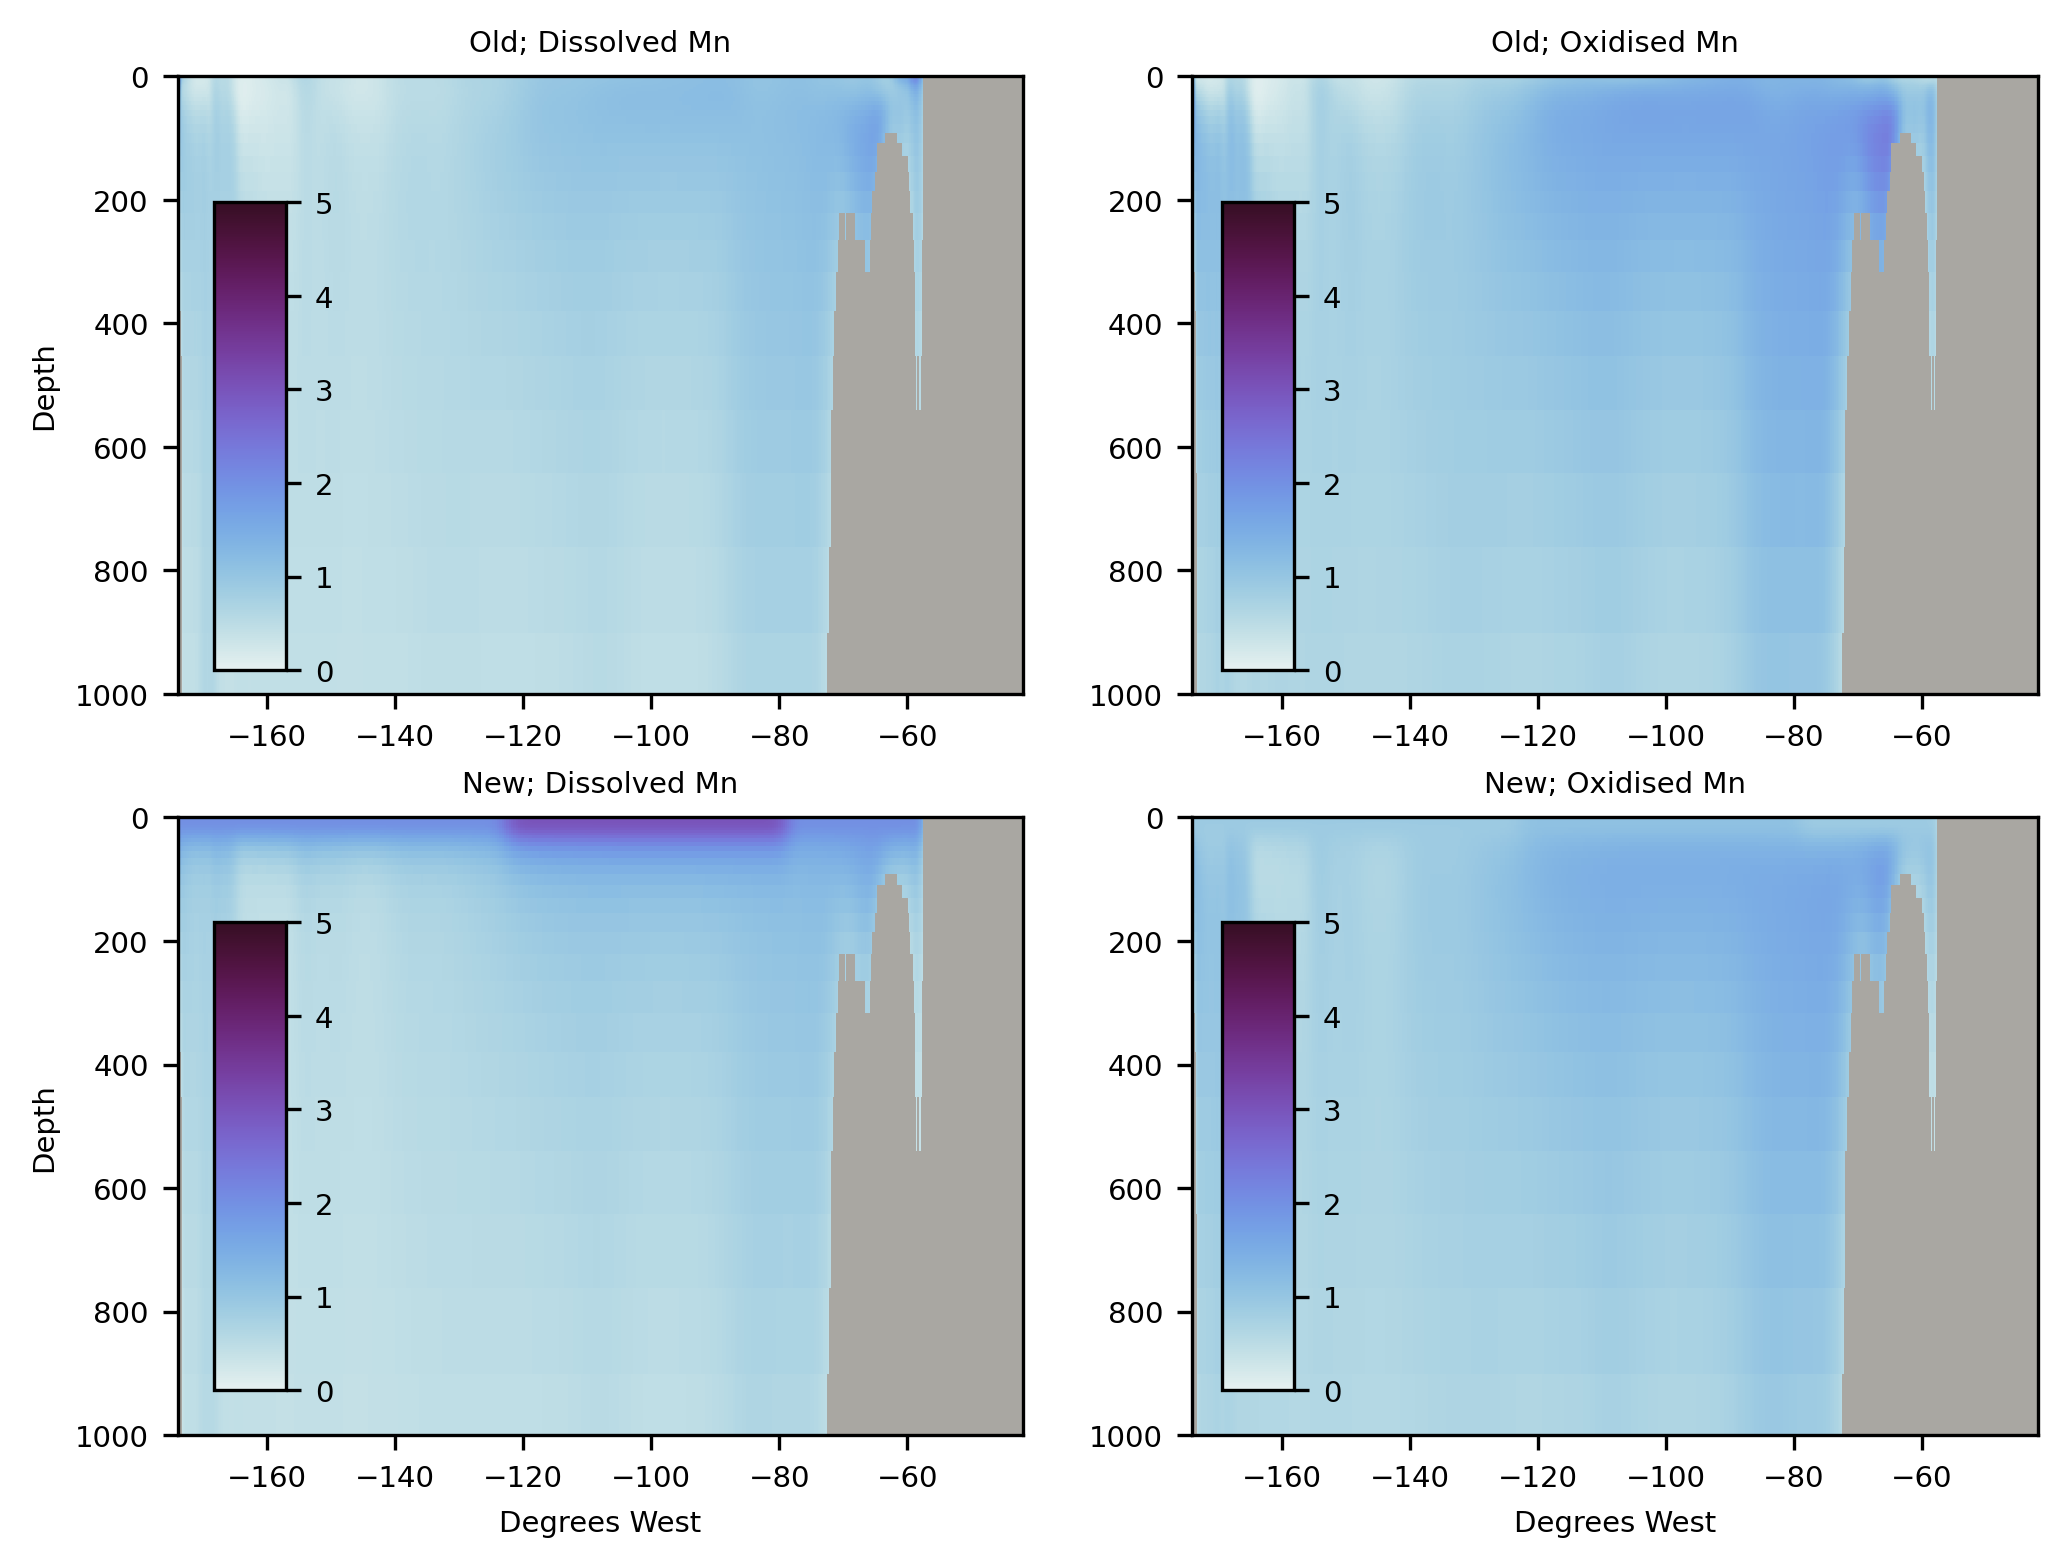

In [52]:
plot_boundary_transect(E_coordinates, dMn_east_old, oMn_east_old, dMn_east_new, oMn_east_new, 1, ylim=(1000,0))

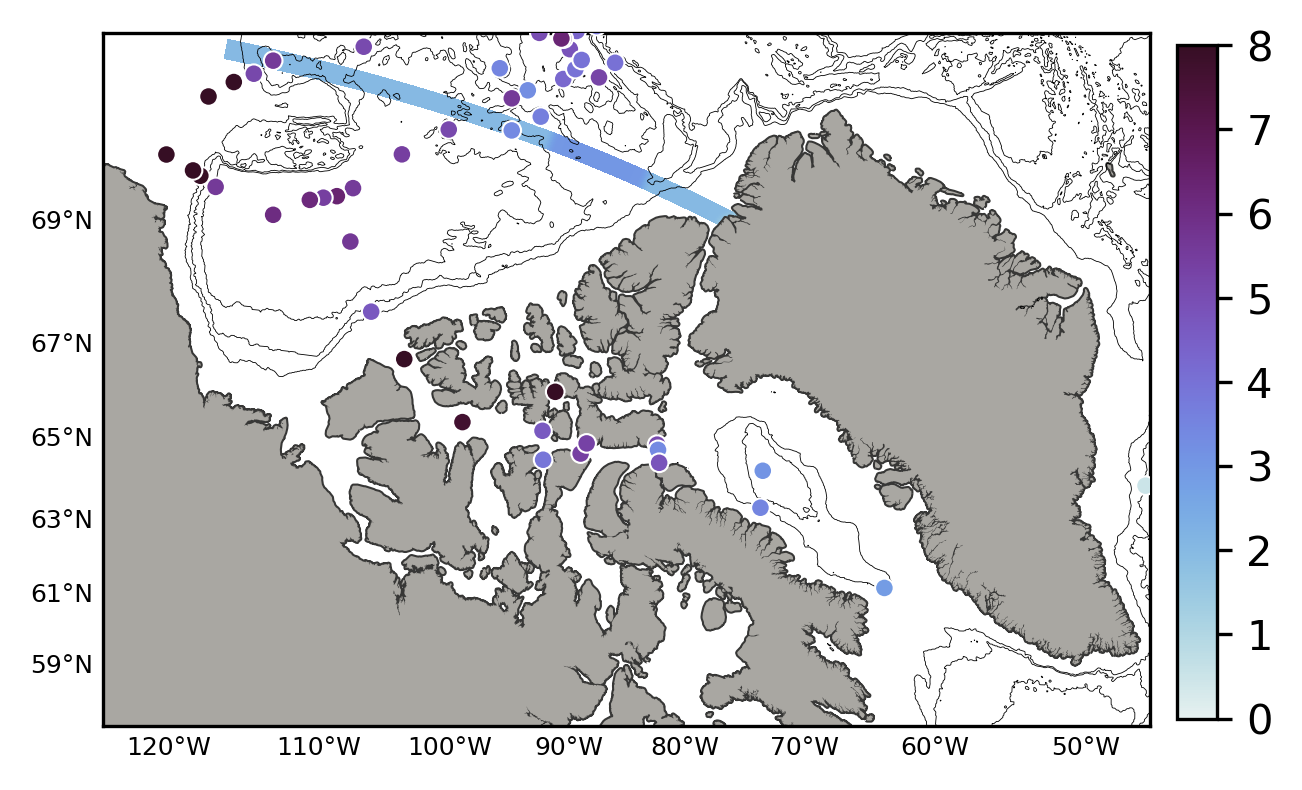

In [53]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------

# add bathymetry contours:
x, y = proj1(lon_model, lat_model)
proj1.contour(x, y, mesh_hdept, levels=[1000,2000,3000], linewidths=0.2, colors='k', zorder=3)

xE, yE = proj1(lon_model[E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]], \
               lat_model[E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]])
CB1 = proj1.pcolormesh(xE, yE, dMn_east_new[0,:,:]*10**9, vmin=0, vmax=8, cmap=cmocean.cm.dense)

# Plot observations over top:
x_GTR, y_GTR = proj1(GTR_lons, GTR_lats)
proj1.scatter(x_GTR, y_GTR, c=GTR_dMn_PML, s=20, zorder=3, edgecolor='w', linewidth=0.5, vmin=0, vmax=8, cmap=cmocean.cm.dense)

cbaxes = fig.add_axes([0.92, 0.2, 0.03, 0.60]) 
CBar = plt.colorbar(CB1, ax=ax1, cax=cbaxes) 

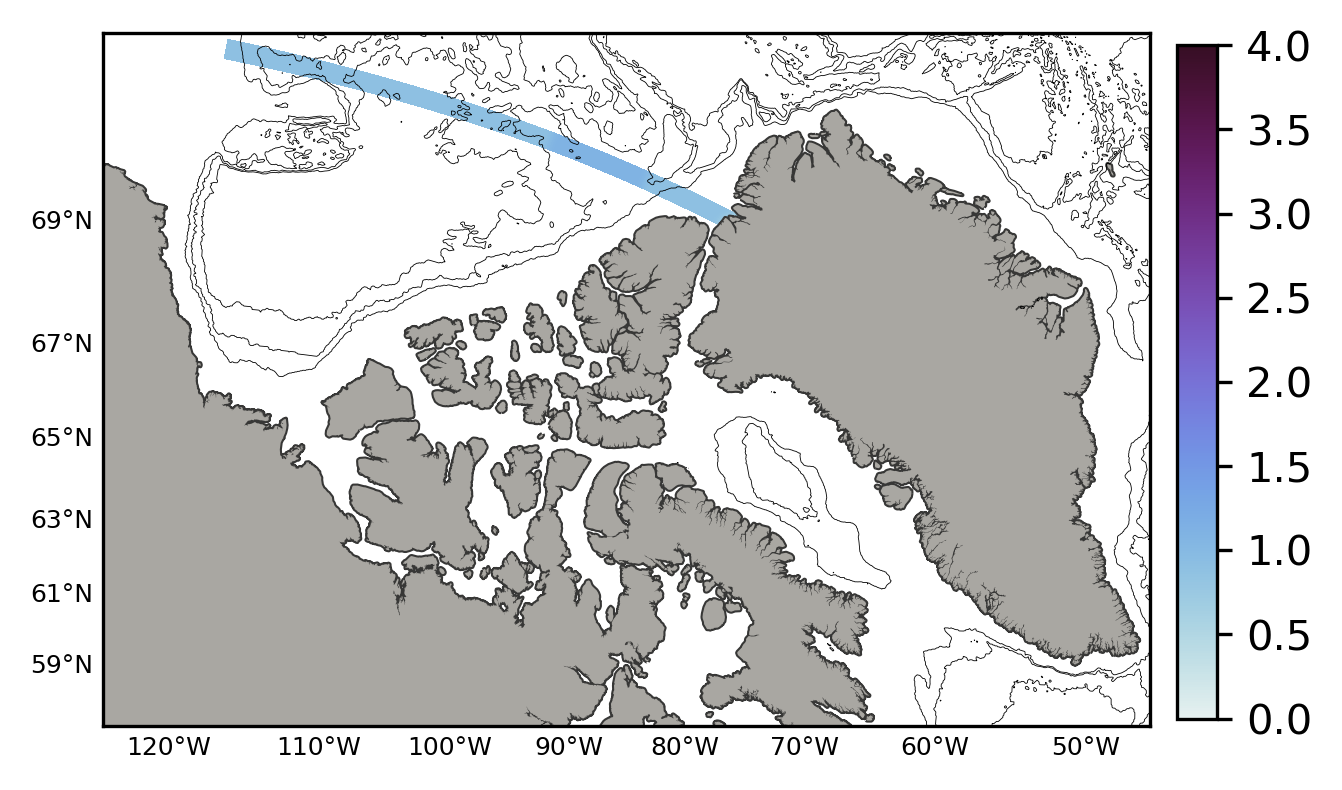

In [54]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------

# add bathymetry contours:
x, y = proj1(lon_model, lat_model)
proj1.contour(x, y, mesh_hdept, levels=[1000,2000,3000], linewidths=0.2, colors='k', zorder=3)

xE, yE = proj1(lon_model[E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]], \
               lat_model[E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]])
CB1 = proj1.pcolormesh(xE, yE, oMn_east_new[0,:,:]*10**9, vmin=0, vmax=4, cmap=cmocean.cm.dense)

cbaxes = fig.add_axes([0.92, 0.2, 0.03, 0.6]) 
CBar = plt.colorbar(CB1, ax=ax1, cax=cbaxes) 

#### Write final boundary condition:

In [137]:
dMn_east_BC, oMn_east_BC = create_boundary(rimwidth_east, dMn_east, oMn_east)

In [119]:
save_BC_file('Mn_East_OBC_20220401.nc', dMn_east_BC, oMn_east_BC)